# 4. GRU based AE
<hr>

In [1]:
import importlib
import argparse
import os
import sys
import argparse
import pandas as pd
import numpy as np
import pickle
import time

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc, precision_recall_curve

%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm

In [4]:
sys.path.insert(0, './../utils/')
from utils import *
from models import *

In [5]:
#Defining parser
name = 'small_log'

parser = {
    'train': True,
    'test': True,
    'model_class': 'GRUAE',
    'model_name': '',
    'data_dir': '../data/',
    'data_file': name + '.csv',
    'anomaly_pct': 0.1,
    'scaler': 'standardization',
    'input_dir': '../input/{}/'.format(name), 
    'batch_size' : 16,
    'epochs' : 100,
    'no_cuda' : False,
    'cuda':True,
    'seed' : 7,
    'clip': 0.25,
    'layer1': 7,
    'lr': 0.001,
    'betas': (0.9, 0.999),   
    'lr_decay': 0.99,
}

args = argparse.Namespace(**parser)
args.output_dir = './output/{0}_{1}_{2}/'.format(name, args.anomaly_pct, args.model_class)

In [6]:
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

In [7]:
args.cuda = not args.no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 2, 'pin_memory': True} if args.cuda else {}

In [8]:
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [9]:
preprocessed_data_name = os.path.join(args.input_dir, 'preprocessed_data_{}.pkl'.format(args.anomaly_pct))

with open(preprocessed_data_name, 'rb') as f:
    input_train = pickle.load(f)
    input_val = pickle.load(f)
    input_test = pickle.load(f)
    pad_index_train = pickle.load(f)
    pad_index_val = pickle.load(f)
    pad_index_test = pickle.load(f)
    
    activity_label_test = pickle.load(f)
    time_label_test = pickle.load(f)
    
    train_case_num = pickle.load(f)
    val_case_num = pickle.load(f)
    test_case_num = pickle.load(f)
    train_row_num = pickle.load(f)
    val_row_num = pickle.load(f)
    test_row_num = pickle.load(f)
    
    cols = pickle.load(f)
    statistics_storage = pickle.load(f)
    
    min_value = pickle.load(f)
    max_value = pickle.load(f)
    mean_value = pickle.load(f)
    std_value = pickle.load(f)
    
    true_time = pickle.load(f)
    true_act = pickle.load(f)
    full_true_time = pickle.load(f)
    full_true_act = pickle.load(f)

## 1) Loading data

In [10]:
# Training data
input_trainLoader = torch.utils.data.DataLoader(input_train, batch_size=args.batch_size, shuffle=False, num_workers=2)
pad_index_trainLoader = torch.utils.data.DataLoader(pad_index_train, batch_size=args.batch_size, shuffle=False, num_workers=2)

In [11]:
# dataframe
normal_df_name = os.path.join(args.input_dir, 'normal_df_{}.csv'.format(args.anomaly_pct))
normal_df = pd.read_csv(normal_df_name)

anomalous_df_name = os.path.join(args.input_dir, 'anomalous_df_{}.csv'.format(args.anomaly_pct))
anomalous_df = pd.read_csv(anomalous_df_name)

In [12]:
# Test
caseid_test = normal_df['CaseID'][-test_row_num:]
normal_df_test = normal_df[-test_row_num:]
anomalous_df_test = anomalous_df[-test_row_num:]

## 2) Building model

### Define model

In [13]:
if args.model_class == 'GRUAE':
    model = GRUAE(input_train.shape[2], args.layer1, 1, args.cuda)

if args.cuda:
    model.cuda()

./../utils\models.py:243: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.gru.weight_ih_l0, gain=np.sqrt(2))
./../utils\models.py:244: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.gru.weight_hh_l0, gain=np.sqrt(2))
./../utils\models.py:266: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.gru.weight_ih_l0, gain=np.sqrt(2))
./../utils\models.py:267: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.gru.weight_hh_l0, gain=np.sqrt(2))
./../utils\models.py:268: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.linear.weight, gain=np.sqrt(2))


RuntimeError: CuDNN error: CUDNN_STATUS_SUCCESS

In [ ]:
model.parameters

### Define loss

In [ ]:
def loss_function(recon_x, x, pad_index):
    MSE = F.mse_loss(recon_x*pad_index, x*pad_index, size_average=False) 
    return MSE

### Define optimizer

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=args.betas)

In [ ]:
#Adjust learning rate per epoch

lambda1 = lambda epoch: args.lr_decay ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])


## 3) Utils

In [ ]:
def save_model(model, epoch, score):
    model_file = os.path.join(args.output_dir, 'model_{}_epoch{}_score{:.4f}.pth'.format(args.model_class, epoch, score))
    torch.save(model.state_dict(), model_file)

In [ ]:
def load_model(model, model_name):
    model_file = os.path.join(args.output_dir, model_name)
    assert os.path.isfile(model_file), 'Error: no model found!'
    model_state = torch.load(model_file)
    model.load_state_dict(model_state)

In [22]:
def val(model, input_val, pad_index_val):
    model.eval()
    input_val = Variable(torch.Tensor(input_val).float())
    pad_index_val = Variable(torch.Tensor(pad_index_val).float())
    
    if args.cuda:
        input_val = input_val.to('cuda')
        pad_index_val = pad_index_val.to('cuda')
    
    recon_val = model(input_val)    
    loss = loss_function(recon_val, input_val, pad_index_val)
    return loss.data[0]/len(input_test.data)

## 4) Train

In [25]:
def train(epoch, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (batch_data, batch_index) in enumerate(zip(input_trainLoader, pad_index_trainLoader)):
        
        batch_data = Variable(batch_data.float())
        batch_index = Variable(batch_index.float())

        if args.cuda:
            batch_data = batch_data.cuda()
            batch_index = batch_index.cuda()
            
        optimizer.zero_grad()
        
        recon_data = model(batch_data)
        loss = loss_function(recon_data, batch_data, batch_index)
        
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        
    return train_loss / len(input_trainLoader.dataset)

In [26]:
if args.train:
    for epoch in range(1, args.epochs + 1):
        init = time.time()
        
        scheduler.step()
        
        train_loss = train(epoch, model, optimizer)
        end_train = time.time()
        val_score = val(model, input_val, pad_index_val)
        
        end = time.time()
        print('====> Epoch {} | Train time: {:.4f} ms| End time: {:.4f} ms | Train loss: {:.4f} | Val loss: {:.4f}'.
              format(epoch, (end_train-init)*1000, (end-init)*1000, train_loss, val_score))
else:
    load_model(model, args.model_name)

C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


====> Epoch 1 | Train time: 2151.8018 ms| End time: 2157.8038 ms | Train loss: 38.3671 | Val loss: 28.8244
====> Epoch 2 | Train time: 1907.4192 ms| End time: 1912.4215 ms | Train loss: 25.0484 | Val loss: 21.7072
====> Epoch 3 | Train time: 1876.0540 ms| End time: 1880.0530 ms | Train loss: 19.0374 | Val loss: 16.4115
====> Epoch 4 | Train time: 1845.1898 ms| End time: 1849.1905 ms | Train loss: 14.6768 | Val loss: 13.2822
====> Epoch 5 | Train time: 1802.0289 ms| End time: 1806.0291 ms | Train loss: 12.7585 | Val loss: 12.3017
====> Epoch 6 | Train time: 1810.3981 ms| End time: 1813.3991 ms | Train loss: 12.1554 | Val loss: 11.9268
====> Epoch 7 | Train time: 1821.0588 ms| End time: 1824.0590 ms | Train loss: 11.8573 | Val loss: 11.6780
====> Epoch 8 | Train time: 1886.4391 ms| End time: 1889.4379 ms | Train loss: 11.6322 | Val loss: 11.4711
====> Epoch 9 | Train time: 1880.6112 ms| End time: 1885.6130 ms | Train loss: 11.4351 | Val loss: 11.2818
====> Epoch 10 | Train time: 1871.913

====> Epoch 79 | Train time: 1882.9873 ms| End time: 1887.9888 ms | Train loss: 8.3823 | Val loss: 8.3182
====> Epoch 80 | Train time: 1885.6971 ms| End time: 1889.6959 ms | Train loss: 8.3762 | Val loss: 8.3123
====> Epoch 81 | Train time: 1843.1847 ms| End time: 1847.1856 ms | Train loss: 8.3702 | Val loss: 8.3063
====> Epoch 82 | Train time: 1825.2718 ms| End time: 1828.2726 ms | Train loss: 8.3642 | Val loss: 8.3004
====> Epoch 83 | Train time: 1806.8328 ms| End time: 1809.8354 ms | Train loss: 8.3582 | Val loss: 8.2945
====> Epoch 84 | Train time: 1897.3541 ms| End time: 1902.3557 ms | Train loss: 8.3522 | Val loss: 8.2886
====> Epoch 85 | Train time: 1863.8091 ms| End time: 1868.8107 ms | Train loss: 8.3463 | Val loss: 8.2828
====> Epoch 86 | Train time: 1862.0474 ms| End time: 1868.0482 ms | Train loss: 8.3404 | Val loss: 8.2771
====> Epoch 87 | Train time: 1817.2660 ms| End time: 1821.2671 ms | Train loss: 8.3346 | Val loss: 8.2715
====> Epoch 88 | Train time: 1822.2330 ms| End

## 5) Predict

In [28]:
if args.test:
    #variables are deprecated
    input_test = Variable(torch.Tensor(input_test).float())
    if args.cuda:
        input_test = input_test.to('cuda')
    
    print('Predicting...')
    recon_test = model(input_test)
    
    print('Separating prediction ...')
    predicted_time, predicted_activity = getPrediction(recon_test, pad_index_test)
    
    print('Done!')

Predicting...
Separating prediction ...
Done!


./../utils\utils.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_values = softmax(recon_test[i, :, 1:])


## 6) Evaluate

### Time

In [31]:
#Fix predicted time
time_df = pd.DataFrame({'CaseID': caseid_test,
                        'PredictedTime': predicted_time})

groupByCase = time_df.groupby(['CaseID'])
fixed_time_df = pd.DataFrame(columns=list(time_df))

for case, group in groupByCase:
    group.iloc[0, 1] = -mean_value/std_value
    fixed_time_df = fixed_time_df.append(group)

In [32]:
fixed_predicted_time = fixed_time_df['PredictedTime']

In [33]:
error = np.abs(true_time - fixed_predicted_time)
error_time_df = pd.DataFrame({'Error': error,
                              'TimeLabel': time_label_test})

In [36]:
error_time_df.Error.dtype

dtype('float64')

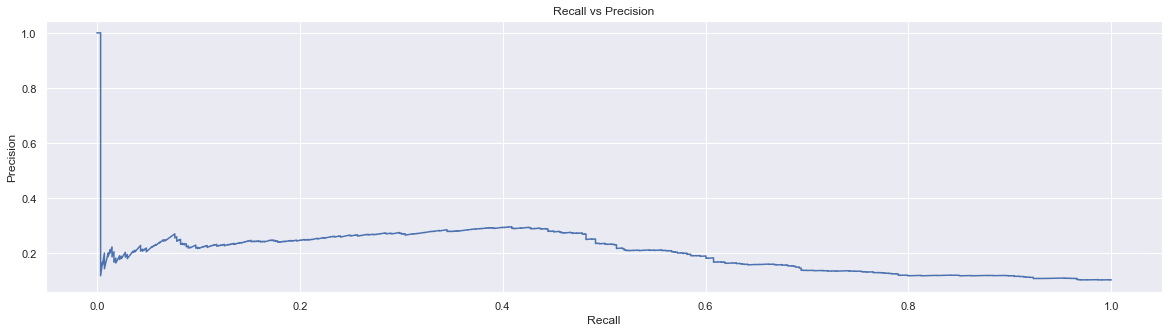

In [38]:
precision, recall, th = precision_recall_curve(error_time_df.TimeLabel.astype(int), error_time_df.Error, pos_label=1)
plt.figure(figsize=(20, 5))
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [39]:
time_threshold = np.mean(error_time_df['Error'])
print('Threshold of Time: {}'.format(time_threshold))

Threshold of Time: 0.02153798998835067


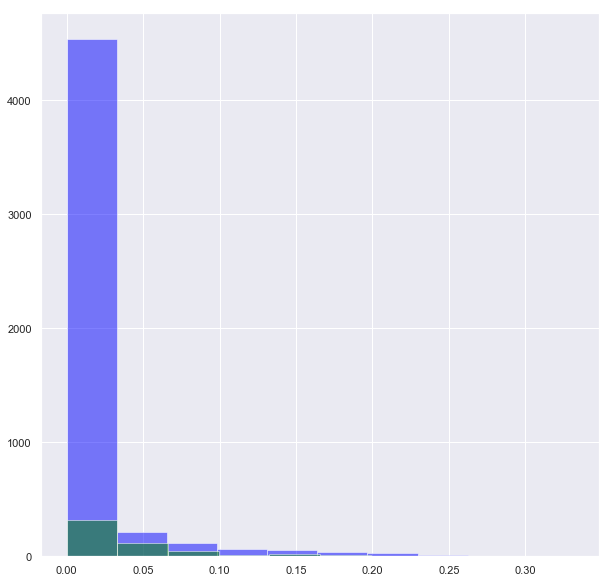

In [40]:
plotOverlapReconstructionError(error_time_df, variable='Time', output_dir=args.output_dir, save=True)

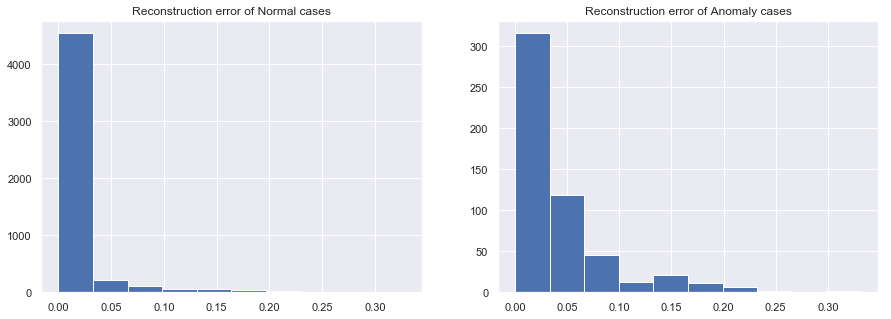

In [41]:
plotReconstructionError(error_time_df, variable='Time')

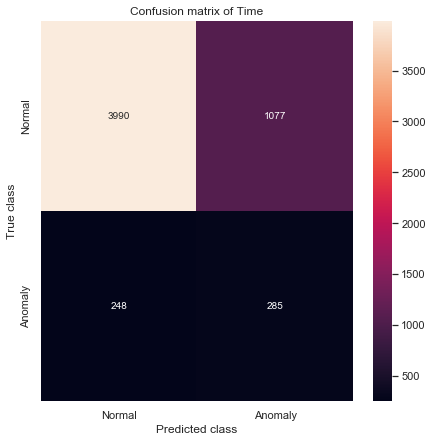

In [42]:
plotConfusionMaxtrix(error_time_df, threshold=time_threshold, variable='Time', output_dir=args.output_dir, save=True)

In [43]:
evalScore(error_time_df, threshold=time_threshold, variable='Time')

-------Evaluation of Time-------


--Weighted Evaluation--
Evaluation of Time
Precision: 0.87
Recall: 0.76
Fscore: 0.80


--Evaluation for each class--
Normal
Precision: 0.94
Recall: 0.79
Fscore: 0.86


Anomaly
Precision: 0.21
Recall: 0.53
Fscore: 0.30


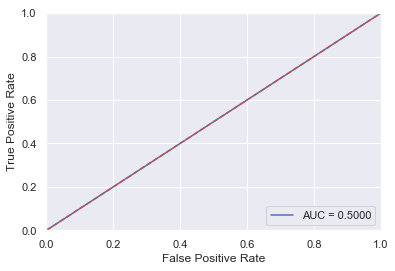

In [44]:
fpr, tpr, thresholds = roc_curve(error_time_df.TimeLabel.astype(int), error_time_df.Error.astype(int), pos_label=1)
roc_auc = auc(fpr, tpr)

#plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(args.output_dir + 'ROC_time.png')
plt.show();

In [45]:
#get submission
if args.scaler == 'standardization':
    inverse_scaled_time = [x*std_value+mean_value for x in fixed_predicted_time]
else:
    inverse_scaled_time = [x*(max_value-min_value)+min_value for x in fixed_predicted_time]
    
predicted_time_label_test = [1 if e > time_threshold else 0 for e in error_time_df.Error.values]

submission_time = pd.DataFrame({'AnomalousDuration': anomalous_df_test['AnomalousDuration'].copy(),
                                'Activity': normal_df_test['Activity'].copy(),
                                'AnomalousCumDuration': anomalous_df_test['AnomalousCumDuration'].copy(),
                                'PredictedCumDuration': inverse_scaled_time,
                                'TimeLabel': time_label_test,
                                'PredictedTimeLabel': predicted_time_label_test})

In [46]:
submission_time.head()

,AnomalousDuration,Activity,AnomalousCumDuration,PredictedCumDuration,TimeLabel,PredictedTimeLabel
22400,0.0,Activity A,0.0,0.000000,0,0
22401,3600.0,Activity B,3600.0,3344.832505,0,1
22402,3600.0,Activity C,7200.0,7051.129341,0,0
22403,3600.0,Activity D,10800.0,10812.749818,0,0
22404,3600.0,Activity E,14400.0,14422.430012,0,0


(22120.7, 28265.3)


C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\AREFA\miniconda3\envs\papercodeenv\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


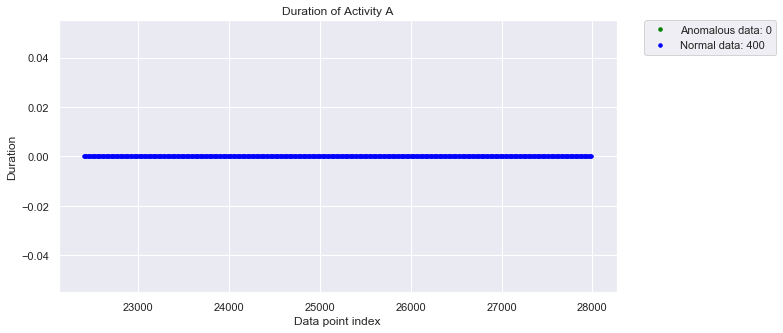

(22121.7, 28266.3)


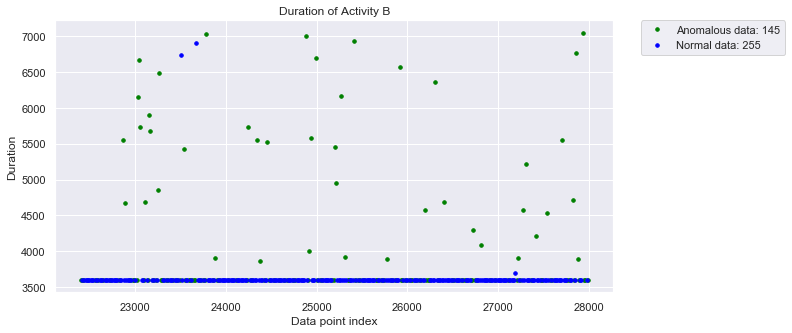

(22122.7, 28267.3)


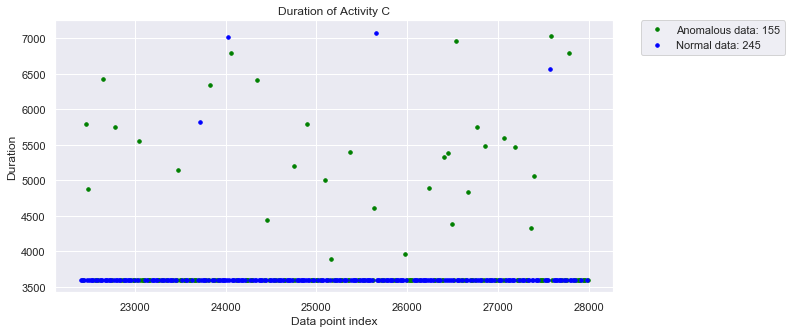

(22123.7, 28268.3)


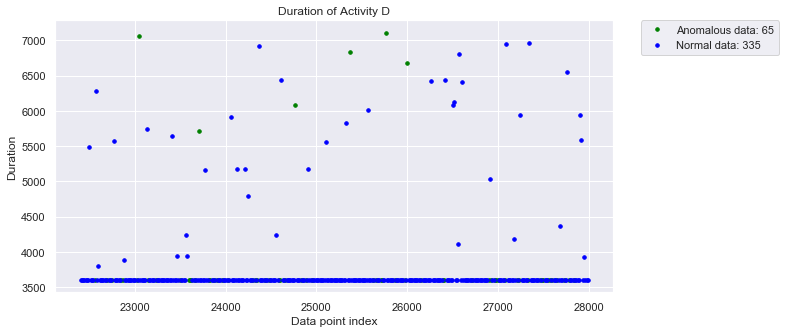

(22124.7, 28269.3)


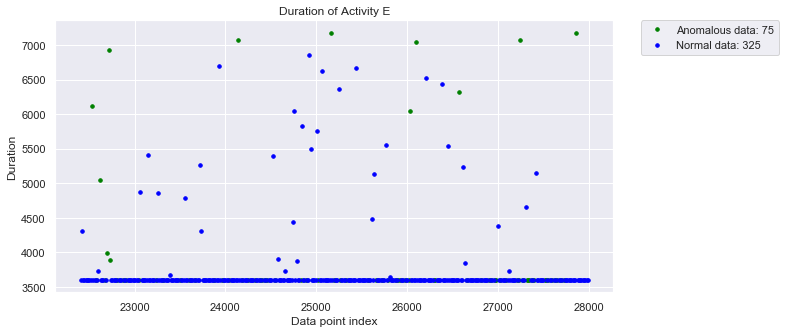

(22133.7, 28278.3)


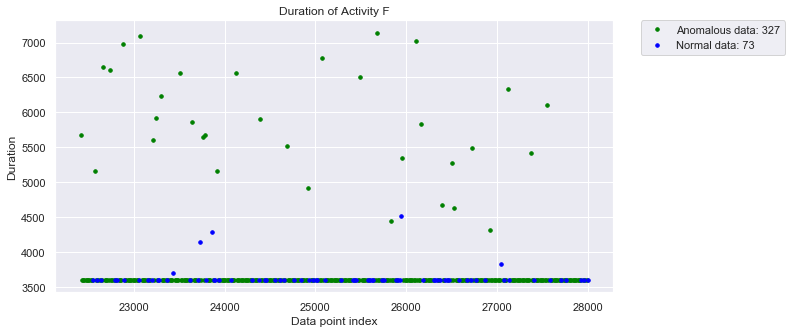

(22125.7, 28270.3)


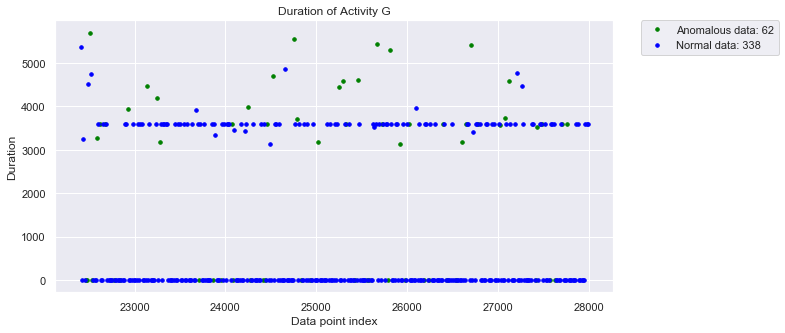

(22132.7, 28277.3)


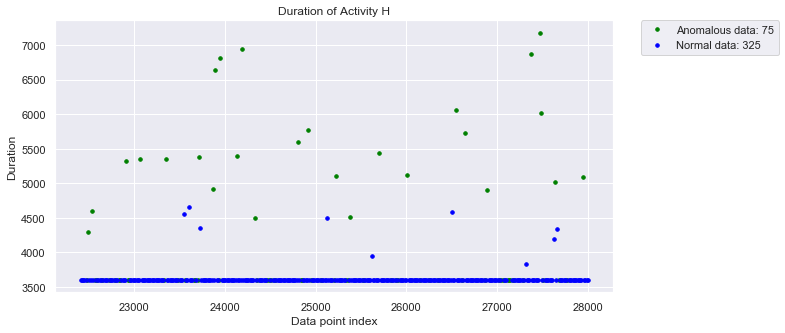

(22128.65, 28274.35)


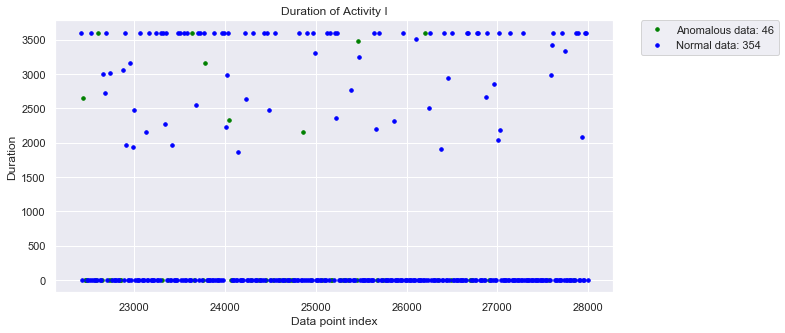

(22129.75, 28273.25)


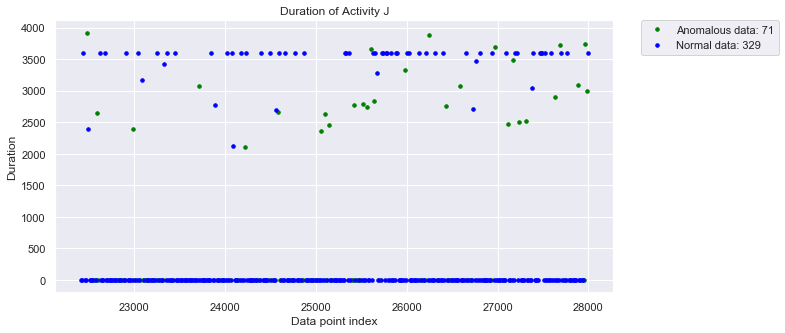

(22127.7, 28272.3)


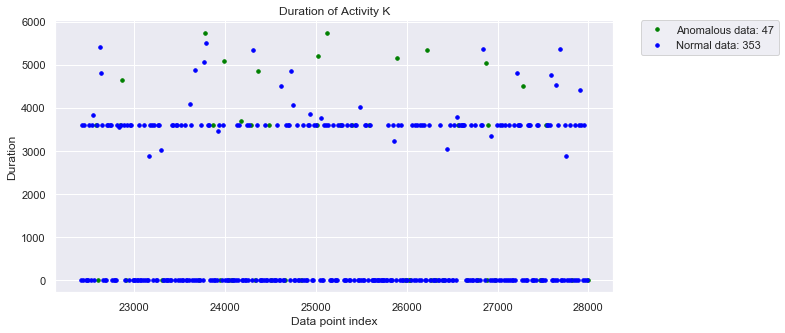

(22131.7, 28276.3)


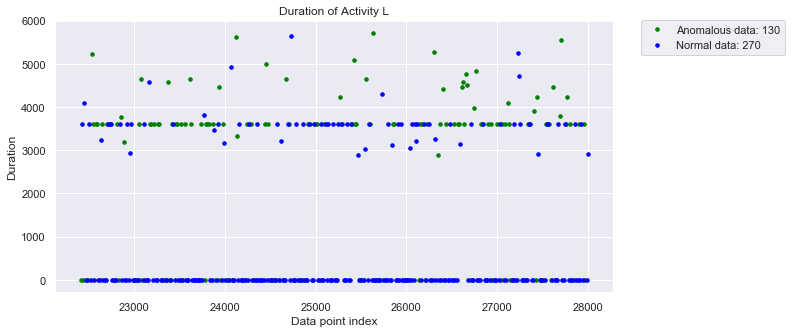

(22126.7, 28271.3)


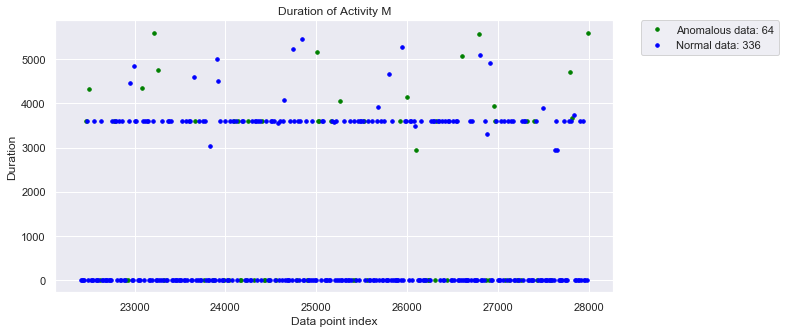

(22130.7, 28275.3)


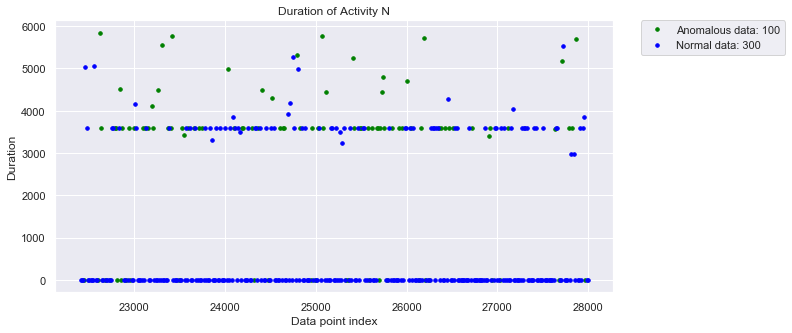

In [47]:
groupByActivity = submission_time.groupby(['Activity'])

for act, group in groupByActivity:
    plotDurationofPredictedTimeLabel(act, group, statistics_storage, args.output_dir, True)

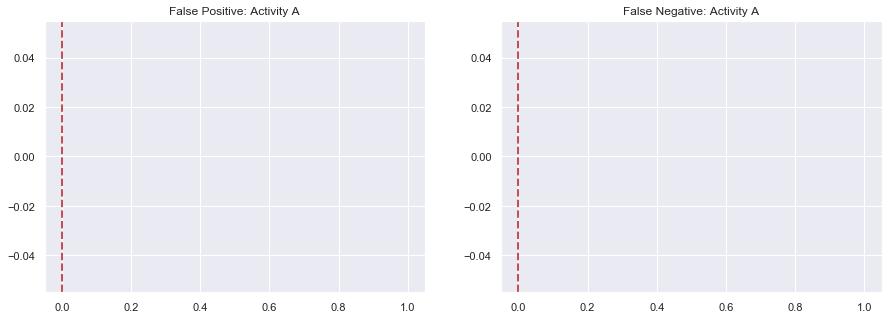

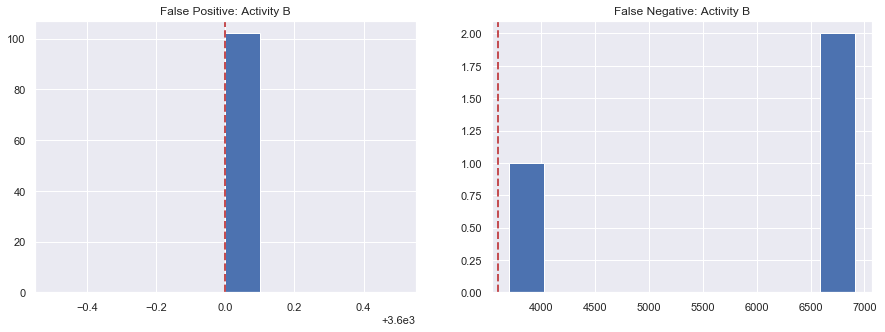

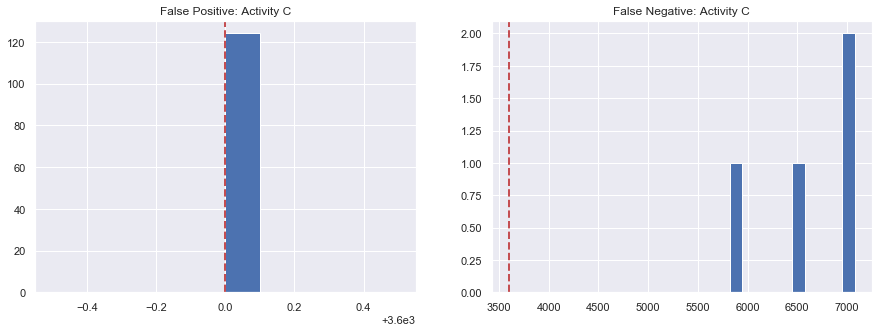

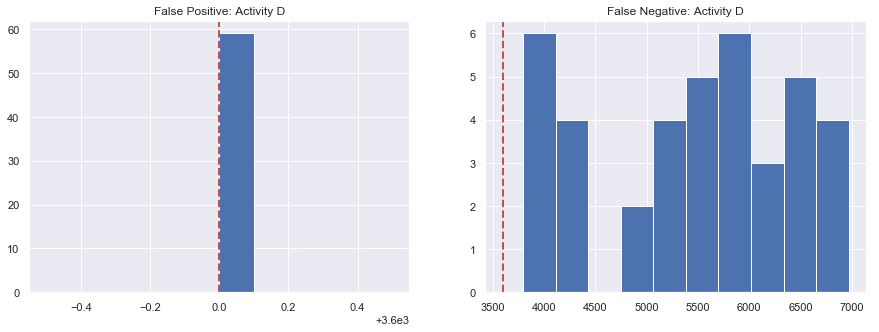

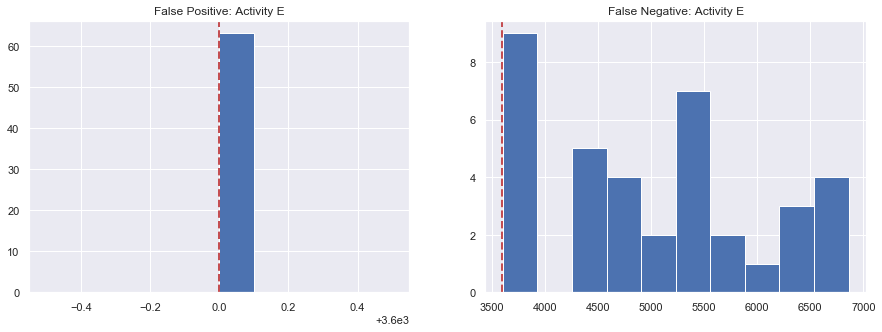

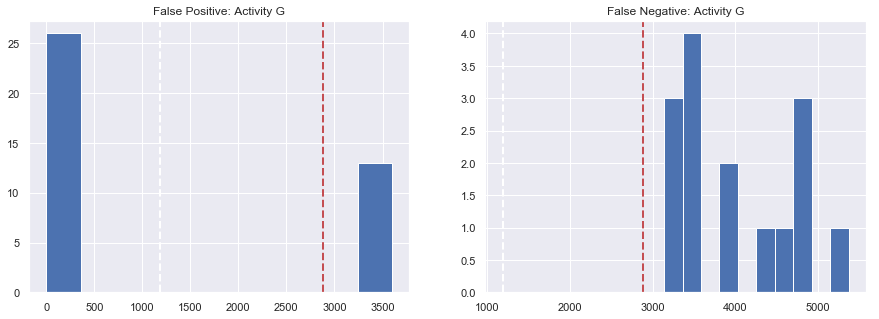

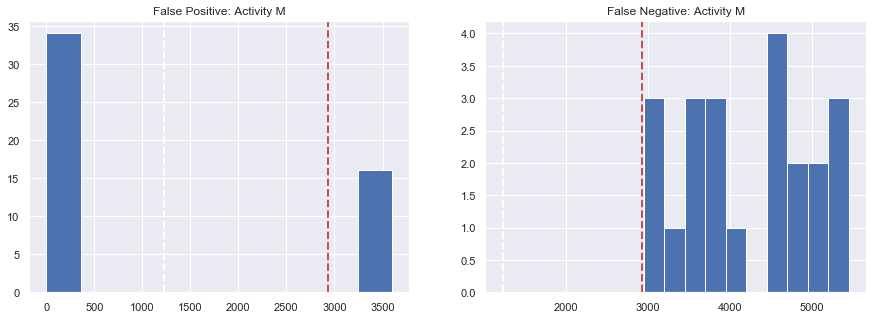

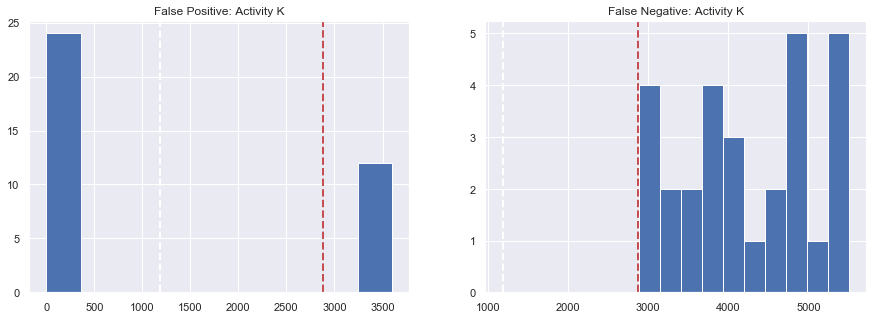

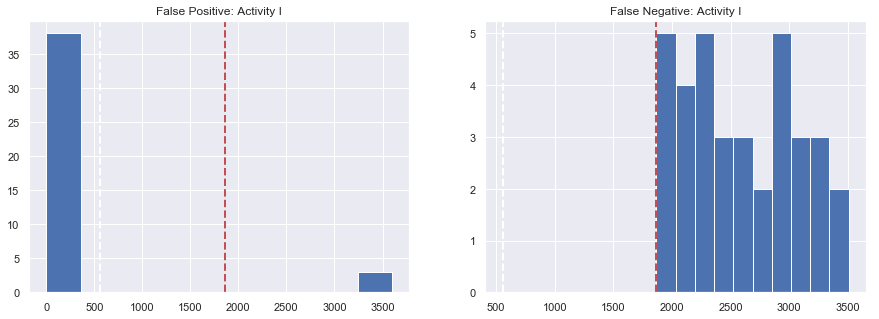

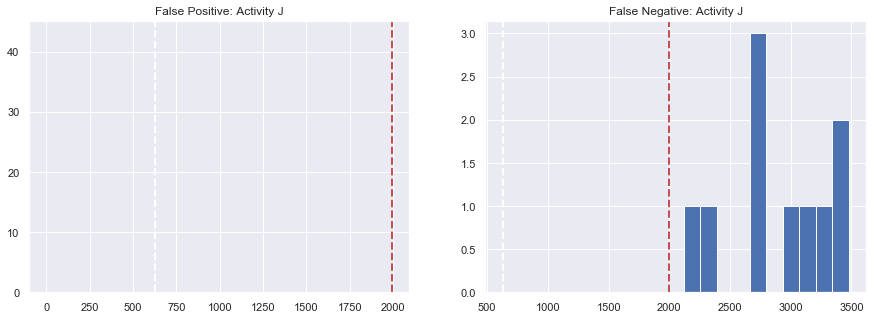

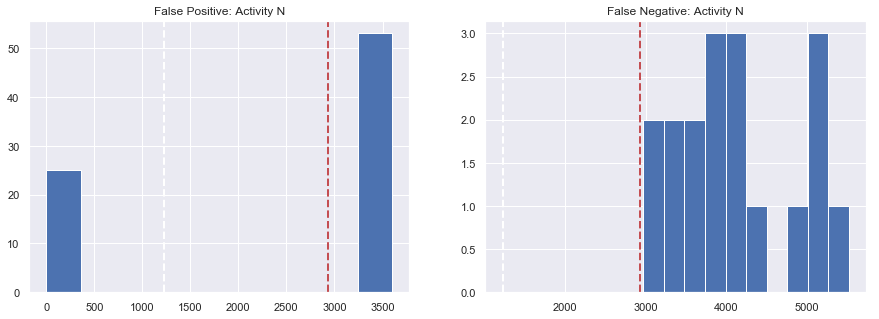

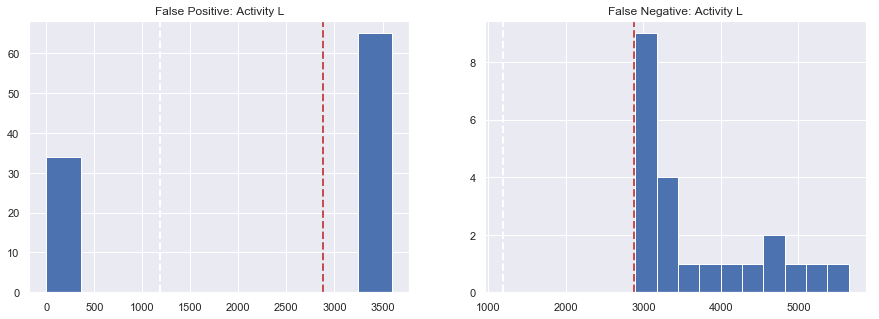

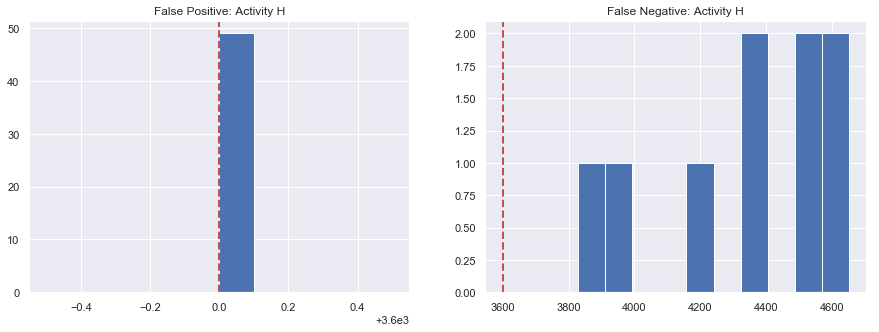

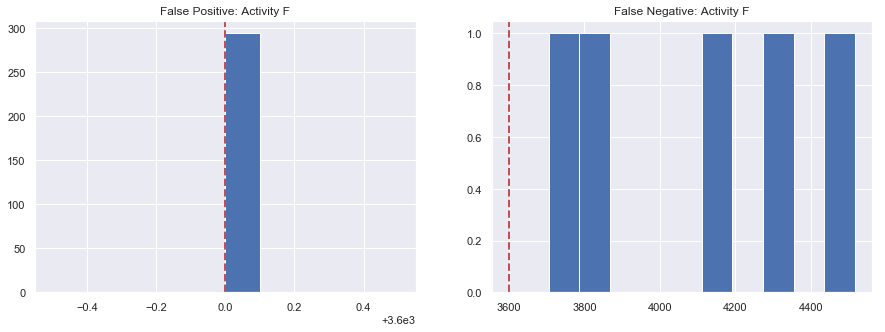

In [50]:
act_list = [i for i in submission_time['Activity'].unique()]
false_positive_df = submission_time[(submission_time['PredictedTimeLabel']== 1)&(submission_time['TimeLabel']== 0)]
false_negative_df = submission_time[(submission_time['PredictedTimeLabel']== 0)&(submission_time['TimeLabel']== 1)]

for act in act_list:
    #statistics_storage[act]
    plotFalseDuration(false_positive_df, false_negative_df, act, statistics_storage)

### Activity

#### i) Threshold based

In [51]:
# error = np.mean(np.power(true_act - predicted_activity, 2), axis = 1)
error = np.mean(np.abs(true_act - predicted_activity), axis = 1)
error_activity_df = pd.DataFrame({'Error': error,
                                  'ActivityLabel': activity_label_test})

In [52]:
error_activity_df.head()

,Error,ActivityLabel
22400,0.120256,0
22401,0.128502,0
22402,0.126745,0
22403,0.123392,0
22404,0.131413,0


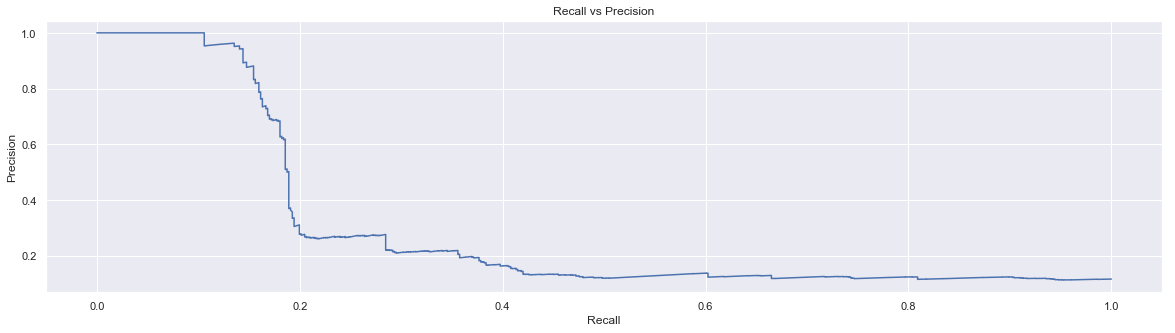

In [53]:
precision, recall, th = precision_recall_curve(error_activity_df.ActivityLabel, error_activity_df.Error, pos_label=1)
plt.figure(figsize=(20, 5))
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [54]:
activity_threshold = np.mean(error_activity_df['Error'])
print('Threshold of Activity: {}'.format(activity_threshold))

Threshold of Activity: 0.1284246050966994


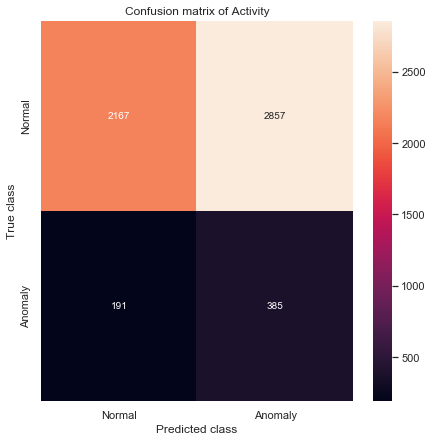

In [55]:
plotConfusionMaxtrix(error_activity_df, activity_threshold, variable='Activity', output_dir=args.output_dir, save=True)

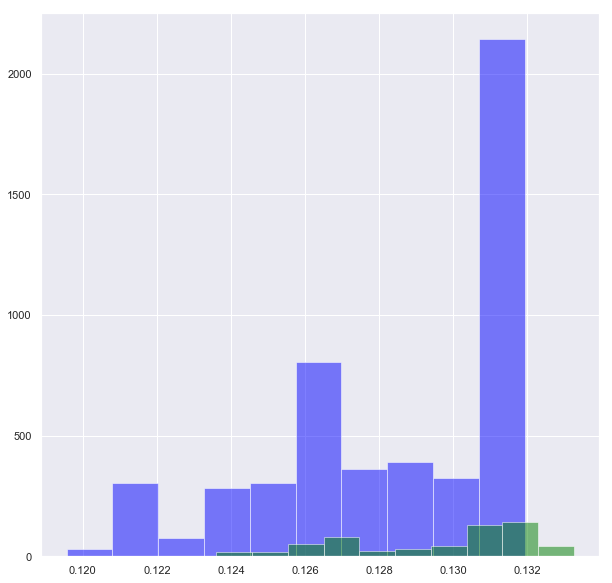

In [56]:
plotOverlapReconstructionError(error_activity_df, variable='Activity', output_dir=args.output_dir, save=True)

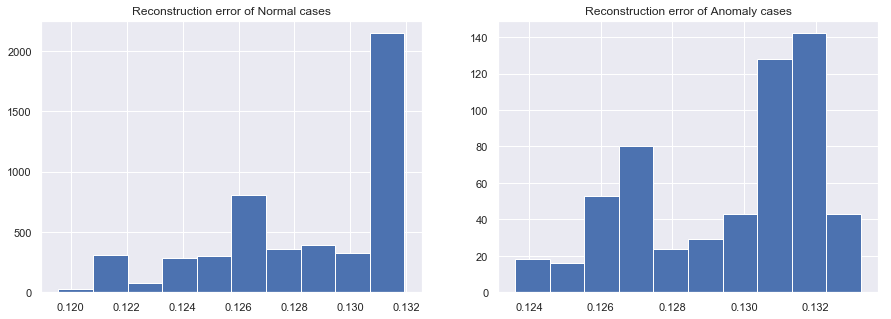

In [57]:
plotReconstructionError(error_activity_df)

In [58]:
evalScore(error_activity_df, activity_threshold, variable='Activity')

-------Evaluation of Activity-------


--Weighted Evaluation--
Evaluation of Activity
Precision: 0.84
Recall: 0.46
Fscore: 0.55


--Evaluation for each class--
Normal
Precision: 0.92
Recall: 0.43
Fscore: 0.59


Anomaly
Precision: 0.12
Recall: 0.67
Fscore: 0.20


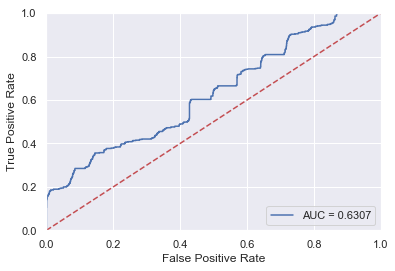

In [59]:
fpr, tpr, thresholds = roc_curve(error_activity_df.ActivityLabel, error_activity_df.Error, pos_label=1)
roc_auc = auc(fpr, tpr)

#plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(args.output_dir+'ROC_Act.png')
plt.show();

#### ii) Argmax based

In [60]:
# evaluate based on classification
predicted_act_df = pd.DataFrame(data=predicted_activity, columns=list(true_act))
predicted_act_label = predicted_act_df.idxmax(axis=1)
true_act_label = true_act.idxmax(axis=1)
predicted_time_label = [0 if a==b else 1 for a, b in zip(true_act_label,predicted_act_label)]

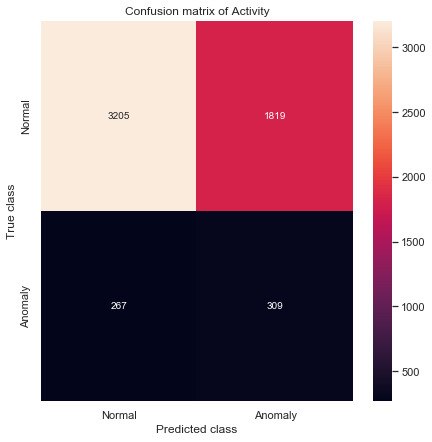

In [61]:
#plot confusion matrix
LABELS = ['Normal', 'Anomaly']
matrix = confusion_matrix(error_activity_df.ActivityLabel.astype('uint8'), predicted_time_label)
plt.figure(figsize=(7, 7))
sns.heatmap(matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title('Confusion matrix of Activity')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [62]:
score = precision_recall_fscore_support(error_activity_df.ActivityLabel.astype('uint8'), predicted_time_label, average='weighted')
    
print('-------Evaluation of Activity-------')
print('\n')
print('--Weighted Evaluation--')
print('Evaluation')
print('Precision: {:.2f}'.format(score[0]))
print('Recall: {:.2f}'.format(score[1]))
print('Fscore: {:.2f}'.format(score[2]))
print('\n')
score_1 = precision_recall_fscore_support(error_activity_df.ActivityLabel.astype('uint8'), predicted_time_label)
print('--Evaluation for each class--')
print('Normal')
print('Precision: {:.2f}'.format(score_1[0][0]))
print('Recall: {:.2f}'.format(score_1[1][0]))
print('Fscore: {:.2f}'.format(score_1[2][0]))
print('\n')
print('Anomaly')
print('Precision: {:.2f}'.format(score_1[0][1]))
print('Recall: {:.2f}'.format(score_1[1][1]))
print('Fscore: {:.2f}'.format(score_1[2][1]))

-------Evaluation of Activity-------


--Weighted Evaluation--
Evaluation
Precision: 0.84
Recall: 0.63
Fscore: 0.70


--Evaluation for each class--
Normal
Precision: 0.92
Recall: 0.64
Fscore: 0.75


Anomaly
Precision: 0.15
Recall: 0.54
Fscore: 0.23


In [63]:
from sklearn.metrics import accuracy_score
accuracy_score(true_act_label, predicted_act_label)

0.62